### short notebook, loading dedalus outputs in xarray datasets with dask arrays

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams.update({"font.family":"serif", "font.size":14})

import os
from pathlib import Path
import itertools

import numpy as np
import xarray as xr

import xrscipy

In [2]:
if False:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(dashboard_address="8787", local_directory=os.getenv("TMPDIR"))
client = Client(cluster) # with distributed cluster
client

<Client: 'tcp://127.0.0.1:34038' processes=8 threads=56, memory=120.00 GiB>

In [2]:
### parameters
data_path = Path("./data_work")
simuls = "modon{0}_N512d_Bu1p0_kai{1}_kax{2}_2nu{3:02d}_Pr1p0"
filetype = "snapshots/snapshots.h5"

#kaps = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
#kapstr = ["{:.02f}".format(kap).replace(".","p") for kap in kaps]
#nus = [16, 17]
#pers = [True, False]

do_savefig = False
dirpic = Path("./figures/all_runs/")

In [3]:
def kap_fmt(k):
    res = ("{:.02f}".format(k)).replace(".","p")
    res = "m"+res[1:] if res.startswith("-") else "p"+res
    return res

import h5py
import dask.array as da
def open_dedalus(path, sim_t_as_coord=True, chunks=None):
    nc = h5py.File(path, "r")

    ds = xr.Dataset(data_vars={key:(tuple([dim.label for dim in val.dims]), 
                                    da.from_array(val, chunks=val.chunks)
                                   ) for key,val in nc["tasks"].items()}
                   )
    if chunks is not None:
        ds = ds.chunk(chunks)

    if "t" in ds.dims:
        ds = ds.assign_coords(iteration=xr.DataArray(nc["scales"]["iteration"][:], dims=('t',)), 
                             sim_time=xr.DataArray(nc["scales"]["sim_time"][:], dims=('t',)))
        if sim_t_as_coord:
            ds = ds.rename({"sim_time":"t"})
        else:
            ds = ds.assign_coords(t=xr.DataArray(nc["scales"]["write_number"][:], dims=('t',)))

    space_dims = ["x", "y"]
    for dim in space_dims:
        if dim in ds.dims:
            ds = ds.assign_coords({dim:xr.DataArray(nc["scales"][dim]["1.0"][:], dims=(dim,))})
            ds.attrs["d"+dim] = ds[dim].diff(dim).mean().values
    return ds

from itertools import product
def dict_product(d):
    keys = d.keys()
    for element in product(*d.values()):
        yield dict(zip(keys, element))
        
def load_big_ds(params_kw, simuls=simuls, data_path=data_path, verbose=False):
    """ params_kw need at least kapext, kapint, nu and pert """
    ds = []
    if isinstance(params_kw, dict):
        params_kw = dict_product(params_kw)
    for p in params_kw:
        kap, kam, nu = p["kapext"], p["kapint"], p["nu"]
        pstr = "p" if p["pert"] else ""
        if verbose:
            print(simuls.format(pstr, kap_fmt(kam), kap_fmt(kap), nu), end="; ")
        sds = open_dedalus(data_path/simuls.format(pstr, kap_fmt(kam), kap_fmt(kap), nu)/"snapshots/snapshots.h5",
                          sim_t_as_coord=False, chunks={"x":-1, "y":-1})
        sds = sds.expand_dims({"kap":[kap], "kam":[kam], "nu":[nu], "pert":[p["pert"]]})
        #sds = sds.assign_coords(nu_val=("nu",1*10**(-nu)))
        ds.append(sds)
    return xr.combine_by_coords(ds)

In [4]:
### processing routines

import scipy.fft as fft

def get_fft_diff(da, axis=-1, d=1.0):
    """ did not tested if da is not 2D """
    n = da.shape[axis]
    k = fft.rfftfreq(n, d=d)*2*np.pi
    k = np.expand_dims(k, tuple([k for k in range(len(da.shape)-1) ]) )
    return fft.irfft(1.j*k*fft.rfft(da, axis=axis), axis=axis)

def get_fft_ddif(da, axis=-1, d=1.0):
    """ 2nd derivative using fft """
    n = da.shape[axis]
    k = fft.rfftfreq(n, d=d)*2*np.pi
    k = np.expand_dims(k, tuple([k for k in range(len(da.shape)-1) ]) )
    return -fft.irfft(k**2*fft.rfft(da, axis=axis), axis=axis)

def wrap_fft_diff(data, coord, d=1.0):
    return xr.apply_ufunc(get_fft_diff, data, input_core_dims=[[coord]], output_core_dims=[[coord]],
                         kwargs={"d":d}, dask="parallelized",  
                         output_dtypes=data.dtype)

def wrap_fft_lap(data, dx=1.0, dy=1.0):
    dxx = xr.apply_ufunc(get_fft_ddif, data, input_core_dims=[["x"]], output_core_dims=[["x"]],
                         kwargs={"d":dx}, dask="parallelized",  
                         output_dtypes=data.dtype)
    dyy = xr.apply_ufunc(get_fft_ddif, data, input_core_dims=[["y"]], output_core_dims=[["y"]],
                         kwargs={"d":dy}, dask="parallelized",  
                         output_dtypes=data.dtype)
    return dxx + dyy
    
def get_grad(ds, what="psi", uv=True):
    rds = xr.Dataset()
    if what in ["psi"]:
        namx, namy = "v", "u"
    elif what in ["b"]:
        namx, namy = "Bx", "By"
    if uv:
        sigx, sigy = 1., -1
    else:
        sigx, sigy = +1., +1.
    rds[namx] = sigx * wrap_fft_diff(ds[what], "x", d=ds.dx)
    rds[namy] = wrap_fft_diff(ds[what], "y", d=ds.dy)
    return rds


In [5]:
from dask.distributed import wait
def custom_distribute(ds_or_da, dist_dims):
    res = []
    if isinstance(dist_dims, str):
        dims = [dist_dims]
    else:
        dims = dist_dims.copy()
    dim = dims.pop(-1)
        
    print("iterating over", dim, end=": ")
    for i in range(ds_or_da[dim].size):
        dsda = ds_or_da.isel({dim:[i]})
        if len(dims)>0:
            r = custom_distribute(dsda, dims)
        else:
            r = dsda.persist()
            _ = wait(r)
            print(i, end=", ")
        res.append(r)
    print("--", dim, "done")
    return xr.concat(res, dim)


In [6]:
### pas optimisé mais ça passe sur 4 coeurs avec 16 Go

def comp_int_field(ds, what, chk={"t":-1}):
    if what == "ME":
        sds = get_grad(ds, "b")
        toplot = .5*(sds.Bx**2 + sds.By**2).mean(dim=("x","y"))
    elif what == "KE":
        sds = get_grad(ds, "psi")
        toplot = .5*(sds.u**2 + sds.v**2).mean(dim=("x","y"))
    elif what == "Z":
        toplot = .5*(ds.vort**2).mean(dim=("x", "y"))
    elif what == "PE":
        toplot = .5*(ds.psi**2).mean(dim=("x", "y"))
    if chk is not None:
        toplot = toplot.chunk(chk)
    return toplot.rename(what)

long_names = {"ME":"mean Magnetic Energy",
              "KE":"mean Kinetic Energy",
              "PE":"mean Potential Energy",
              "Z":"mean squared vorticity (enstropy)"}


In [9]:
params = {"kapext":[-0.1, -0.05, 0, 0.02, 0.05, 0.1, 0.2], 
          "kapint":[0, 0.02, 0.05, 0.1, 0.2], 
          "pert":[True], "nu":[60, 70]}
       #   "pert":[True, False], "nu":[15, 16, 17]}

#params.update({k:params[k][-1:] for k in ["kapint"]})
%time ds = load_big_ds(params)
ds

CPU times: user 5.9 s, sys: 364 ms, total: 6.26 s
Wall time: 9.01 s


<xarray.Dataset>
Dimensions:    (kap: 7, kam: 5, nu: 2, pert: 1, t: 160, x: 704, y: 512)
Coordinates:
  * kap        (kap) float64 -0.1 -0.05 0.0 0.02 0.05 0.1 0.2
  * kam        (kam) float64 0.0 0.02 0.05 0.1 0.2
  * nu         (nu) int64 60 70
  * pert       (pert) bool True
    iteration  (nu, kam, kap, t) int64 0 352 702 1053 ... 35343 35440 35537
    sim_time   (nu, kam, kap, t) float64 0.0 0.5012 1.0 1.501 ... 78.5 79.0 79.5
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * x          (x) float64 -6.875 -6.855 -6.836 -6.816 ... 6.816 6.836 6.855
  * y          (y) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
Data variables:
    b          (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 704, 512), meta=np.ndarray>
    psi        (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 704, 512), meta=np.ndarray>
    vort       (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 704, 512), meta=np.ndarray>
Attributes:
    dx:       0.01953125
    dy:       0.019531249999999997

In [19]:
client.restart()

<Client: 'tcp://127.0.0.1:33164' processes=0 threads=0, memory=0 B>

In [ ]:
%%time
#### compute
for what in ["ME","KE","Z", "PE"]:
    print("computing", what)
    sds = custom_distribute(comp_int_field(ds, what), ["kap", "kam"]).to_dataset()
    sds = sds.assign_coords(pert=sds.coords["pert"].astype(int))
    sds.to_netcdf(what+".nc")
    client.restart()#.persist()
del sds

print("now merging")
ds_synth = xr.merge([xr.open_dataset(what+".nc") for what in ["ME", "KE", "PE", "Z"]])
ds_synth["Etot"] = ds_synth.KE + ds_synth.PE + ds_synth.ME
if True:
    print("now storing")
    ds_synth.to_netcdf("tseries_integrated_vs-kap-kam_2nu_extp.nc")
    ds_synth = xr.open_dataset("tseries_integrated_vs-kap-kam_2nu_extp.nc")
ds_synth

computing ME
iterating over kam: iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
-- kam done
computing KE
iterating over kam: iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
-- kam done
computing Z
iterating over kam: iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 3, 4, 5, 6, -- kap done
iterating over kap: 0, 1, 2, 

## Plotting

In [3]:
def myexpander(ds):
    for c in ["sim_time","iteration"]:
        if "nu" not in ds[c].dims:
            ds[c] = ds[c].expand_dims(["nu"])
    return ds

dst = xr.open_dataset("tseries_integrated_vs-kap-kam_2nu_extp.nc")
if "Etot" not in dst:
    dst["Etot"] = dst.KE + dst.PE + dst.ME
if False: 
    #dsp = xr.open_dataset("tseries_integrated_vs-kap-kam_2nu_ext.nc")
    dsp = xr.open_dataset("tseries_integrated_vs-kap-kam_2nu_extp.nc")
    if "Etot" not in dsp:
        dsp["Etot"] = dsp.KE + dsp.PE + dsp.ME
    dst = myexpander(dst).merge(myexpander(dsp))
dst

<xarray.Dataset>
Dimensions:    (kap: 7, kam: 5, nu: 2, pert: 1, t: 160)
Coordinates:
  * kap        (kap) float64 -0.1 -0.05 0.0 0.02 0.05 0.1 0.2
  * kam        (kam) float64 0.0 0.02 0.05 0.1 0.2
  * nu         (nu) int64 60 70
  * pert       (pert) int64 1
    iteration  (nu, kam, kap, t) int64 ...
    sim_time   (nu, kam, kap, t) float64 ...
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
Data variables:
    ME         (kap, kam, nu, pert, t) float64 ...
    KE         (kap, kam, nu, pert, t) float64 ...
    PE         (kap, kam, nu, pert, t) float64 ...
    Z          (kap, kam, nu, pert, t) float64 ...
    Etot       (kap, kam, nu, pert, t) float64 ...

In [14]:
cols = {"KE":"tab:blue", "PE":"tab:orange", "ME":"tab:green", "Etot":"black"}
nu, pert, kap, kam = 33, [0, 1], [0.1, 0.2], 0.2
dsp = dst.sel(nu=nu, pert=pert, kap=kap, kam=kam)
dsp = dsp.stack(simu=[d for d in ["nu", "pert", "kap", "kam"] if d in dsp.dims])
if False: # remove specific cases
    dsp = dsp.where(~((dsp.kap==0)*(dsp.kam==0)), drop=True)
dsp

<xarray.Dataset>
Dimensions:    (t: 160, simu: 4)
Coordinates:
    kam        float64 0.2
    nu         int64 33
    iteration  (t, simu) int64 0 0 0 0 353 355 ... 34790 43386 42985 42518 34844
    sim_time   (t, simu) float64 0.0 0.0 0.0 0.0 0.5014 ... 79.5 79.5 79.5 79.5
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * simu       (simu) MultiIndex
  - pert       (simu) int64 0 0 1 1
  - kap        (simu) float64 0.1 0.2 0.1 0.2
Data variables:
    ME         (t, simu) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    KE         (t, simu) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PE         (t, simu) float64 0.01537 0.01059 0.01537 ... 0.002847 0.001882
    Z          (t, simu) float64 0.675 0.4727 0.675 ... 0.2365 0.2554 0.05799
    Etot       (t, simu) float64 nan nan nan nan nan nan ... nan nan nan nan nan

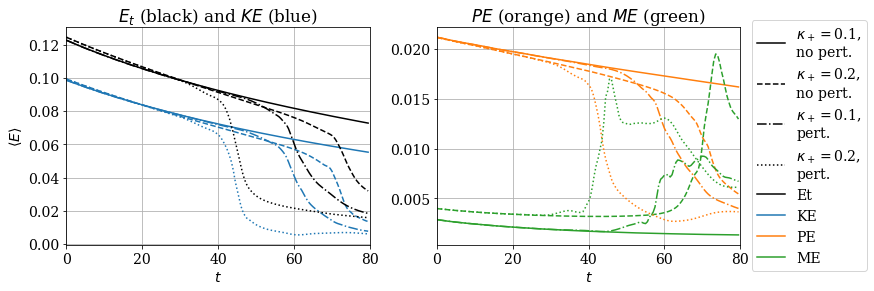

In [19]:
### this version for plotting 4 different simulations on a same plot
# 2 pert, 2 kap
lstys = ["-", "--", "-.", ":"]
alphs = [1, 1, 1, 1]
strpert = lambda x: "no pert." if x==0 else "pert."

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
whatax = {"KE":axs[0], "Etot":axs[0], "PE":axs[1], "ME":axs[1]}
dicl = {}
for il in range(dsp.simu.size):
    for what,ax in whatax.items():
        dicl[(il,what)], = dsp.isel(simu=il)[what].plot.line(ax=ax, x="sim_time", color=cols[what], 
                                          linestyle=lstys[il], alpha=alphs[il])
for ax in axs:
    ax.grid(True)
    ax.set_xlim([round(float(dsp.sim_time.min())), round(float(dsp.sim_time.max()))])
    ax.set_ylabel('')
    ax.set_xlabel(r'$t$')
axs[0].set_ylabel(r'$\langle E \rangle$')
axs[0].set_title(r'$E_t$ (black) and $KE$ (blue)')
axs[1].set_title(r'$PE$ (orange) and $ME$ (green)')
to_leg = [(0,"Etot"), (1,"Etot"), (2,"Etot"), (3,"Etot"), 
          (0,"Etot"), (0, "KE"), (0, "PE"), (0,"ME")]
lins = [dicl[k] for k in to_leg]
labs = [r'$\kappa_+=$'+"{:.1f}".format(float(dsp.isel(simu=[il]).kap)) + 
        ',\n'+strpert(dsp.isel(simu=[il]).pert)
        for il in range(dsp.simu.size)
       ]
labs += ["Et", "KE", "PE", "ME"]
fig.subplots_adjust(right=0.85, left=.07, wspace=.22)
fig.legend(lins, labs, bbox_to_anchor=(1.005,.93), bbox_transform=fig.transFigure)
if False:
    kapstr = "{:.2f}".format(kam).replace(".","p")
    figname = "energy_evol_vs-pert_nu{}_kam{}".format(nu, kapstr)
    fig.savefig(f"./figures/paper/{figname}.pdf")

AttributeError: 'Dataset' object has no attribute 'simu'

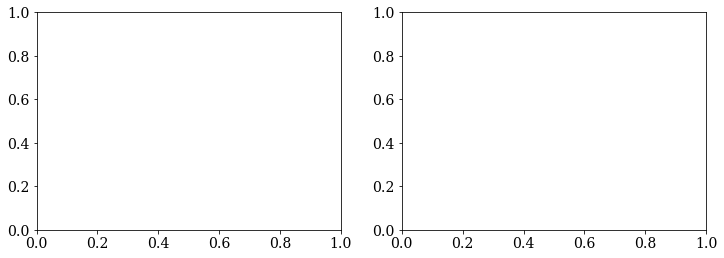

In [13]:
### this version for plotting 3 different simulations on a same plot
# single nu, single pert, 3 different couples of (kap, kam)
lstys = ["-", "--", "-."]
alphs = [.7, 1, 1]
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
whatax = {"KE":axs[0], "Etot":axs[0], "PE":axs[1], "ME":axs[1]}
dicl = {}
for il in range(dsp.simu.size):
    for what,ax in whatax.items():
        dicl[(il,what)], = dsp.isel(simu=il)[what].plot.line(ax=ax, x="sim_time", color=cols[what], 
                                          linestyle=lstys[il], alpha=alphs[il])
for ax in axs:
    ax.grid(True)
    ax.set_xlim([round(float(dsp.sim_time.min())), round(float(dsp.sim_time.max()))])
    ax.set_ylabel('')
    ax.set_xlabel(r'$t$')
axs[0].set_ylabel(r'$\langle E \rangle$')
axs[0].set_title(r'$E_t$ (black) and $KE$ (blue)')
axs[1].set_title(r'$PE$ (orange) and $ME$ (green)')
to_leg = [(0,"Etot"), (1,"Etot"), (2,"Etot"), (0,"Etot"), (0, "KE"), (0, "PE"), (0,"ME")]
lins = [dicl[k] for k in to_leg]
labs = [r'$\kappa_+=$'+"{:.1f}".format(float(dsp.isel(simu=[il]).kap)) + 
        ',\n'+r'$\kappa_-=$'+"{:.1f}".format(float(dsp.isel(simu=[il]).kam)) 
        for il in range(dsp.simu.size)
       ]
labs += ["Et", "KE", "PE", "ME"]
fig.subplots_adjust(right=0.85, left=.07, wspace=.22)
fig.legend(lins, labs, bbox_to_anchor=(1.,.9), bbox_transform=fig.transFigure)
if False:
    kapstr = "{:.2f}".format(max(kap+kam)).replace(".","p")
    figname = "energy_evol_nu{}_pert{}_kapm{}".format(nu, pert, kapstr)
    fig.savefig(f"./figures/paper/{figname}.pdf")

In [19]:
it_c = 10
dsp = dst.sel(nu=70)

dKEdt = dsp["KE"].differentiate("t").rolling(t=3).mean()
dMEdt = dsp["ME"].differentiate("t").rolling(t=3).mean()
proxy = (-dsp["KE"].differentiate("t")/dsp["KE"]).argmax("t")
crit = (proxy>it_c) #* (dMEdt.isel(t=proxy)>0)
tinst = dsp.sim_time.isel(t=proxy).where(crit)

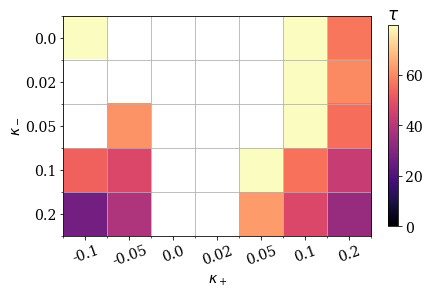

In [20]:
toplot = tinst.values
cmap = "magma"

ylab = tinst.coords[tinst.dims[0]].values
xlab = tinst.coords[tinst.dims[1]].values
xticks, yticks = np.arange(xlab.size), np.arange(ylab.size)
xtickm, ytickm = np.arange(xlab.size+1)-.5, np.arange(ylab.size+1)-.5

fig, ax = plt.subplots(1, 1, figsize=(6,5))
hpc = ax.imshow(tinst.values, cmap=cmap, 
                vmin=0, #dsp.sim_time.isel(t=it_c).mean().values, 
               vmax = dsp.sim_time.max().values)
ax.set_xticks(xticks)
ax.set_xticks(xtickm, minor=True)
ax.set_xticklabels(xlab, rotation=20)
ax.set_yticks(yticks, location="top")
ax.set_yticks(ytickm, minor=True)
ax.set_yticklabels(ylab)
ax.grid(True, which="minor")
hpl = plt.colorbar(hpc, ax=ax, fraction=.03)
ax.set_xlabel(r'$\kappa_+$')
ax.set_ylabel(r'$\kappa_-$')
hpl.ax.set_title(r'$\tau$')
if True:
    fig.savefig("figures/paper/instab_timescale_nu70_pert_ext.pdf")

In [27]:
(-dKEdt/dsp.KE).sel(kap=-.1, kam=.05).squeeze().plot()

In [22]:
### compare at different nus
cols = {"KE":"tab:blue", "PE":"tab:orange", "ME":"tab:green", "Etot":"black"}

nu, pert, kap, kam = [33, 60, 70], 1, 0.2, 0.2
dsp = dst.sel(nu=nu, pert=pert, kap=kap, kam=kam)
dsp = dsp.stack(simu=[d for d in ["nu", "pert", "kap", "kam"] if d in dsp.dims])
if False: # remove specific cases
    dsp = dsp.where(~((dsp.kap==0)*(dsp.kam==0)), drop=True)
dsp

<xarray.Dataset>
Dimensions:    (t: 160, simu: 3)
Coordinates:
    kam        float64 0.2
    pert       int64 1
    kap        float64 0.2
    iteration  (t, simu) float64 0.0 0.0 0.0 ... 3.484e+04 4.432e+04 3.554e+04
    sim_time   (t, simu) float64 0.0 0.0 0.0 0.5011 ... 79.0 79.5 79.5 79.5
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * simu       (simu) MultiIndex
  - nu         (simu) int64 33 60 70
Data variables:
    ME         (t, simu) float64 0.002894 0.002894 ... 0.007507 0.008136
    KE         (t, simu) float64 0.07185 0.07185 0.07185 ... 0.00571 0.005957
    PE         (t, simu) float64 0.01536 0.01536 0.01536 ... 0.002156 0.001965
    Z          (t, simu) float64 0.6817 0.6817 0.6817 ... 0.05799 0.1609 0.3507
    Etot       (t, simu) float64 0.0901 0.0901 0.0901 ... 0.0111 0.01537 0.01606

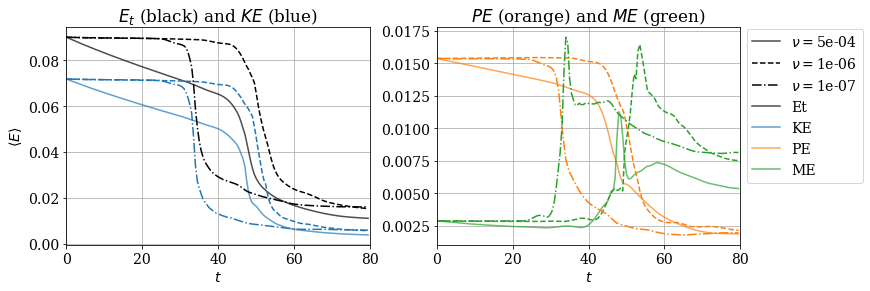

In [24]:
### this version for plotting 3 different simulations on a same plot
# single nu, single pert, 3 different couples of (kap, kam)
lstys = ["-", "--", "-."]
alphs = [.7, 1, 1]
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
whatax = {"KE":axs[0], "Etot":axs[0], "PE":axs[1], "ME":axs[1]}
dicl = {}
for il in range(dsp.simu.size):
    for what,ax in whatax.items():
        dicl[(il,what)], = dsp.isel(simu=il)[what].plot.line(ax=ax, x="sim_time", color=cols[what], 
                                          linestyle=lstys[il], alpha=alphs[il])
for ax in axs:
    ax.grid(True)
    ax.set_xlim([round(float(dsp.sim_time.min())), round(float(dsp.sim_time.max()))])
    ax.set_ylabel('')
    ax.set_xlabel(r'$t$')
axs[0].set_ylabel(r'$\langle E \rangle$')
axs[0].set_title(r'$E_t$ (black) and $KE$ (blue)')
axs[1].set_title(r'$PE$ (orange) and $ME$ (green)')
to_leg = [(0,"Etot"), (1,"Etot"), (2,"Etot"), (0,"Etot"), (0, "KE"), (0, "PE"), (0,"ME")]
lins = [dicl[k] for k in to_leg]
labs = [r'$\nu=$'+"{:.0e}".format(float(10**(-dsp.isel(simu=[il]).nu/10))) 
        for il in range(dsp.simu.size)
       ]
labs += ["Et", "KE", "PE", "ME"]
fig.subplots_adjust(right=0.85, left=.07, wspace=.22)
fig.legend(lins, labs, bbox_to_anchor=(1.,.9), bbox_transform=fig.transFigure)
if True:
    kapstr = "{:.2f}".format(max(kap,kam)).replace(".","p")
    figname = "energy_evol_vs-nu_pert{}_kapm{}".format(pert, kapstr)
    fig.savefig(f"./figures/paper/{figname}.pdf")

In [12]:
dsp.isel(simu=[0])

<xarray.Dataset>
Dimensions:    (t: 160, simu: 1)
Coordinates:
    kap        float64 0.2
    kam        float64 0.2
    pert       int64 1
    iteration  (t, simu) float64 0.0 355.0 709.0 ... 3.35e+04 3.355e+04 3.36e+04
    sim_time   (t, simu) float64 0.0 0.5009 1.001 1.5 ... 78.01 78.51 79.0 79.51
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * simu       (simu) MultiIndex
  - nu         (simu) int64 33
Data variables:
    ME         (t, simu) float64 0.003996 0.003964 ... 0.006112 0.006118
    KE         (t, simu) float64 0.09931 0.09888 0.09844 ... 0.006149 0.006048
    PE         (t, simu) float64 0.02117 0.02113 0.02109 ... 0.00366 0.003648
    Z          (t, simu) float64 0.9454 0.9491 0.9416 ... 0.08889 0.08857
    Etot       (t, simu) float64 nan nan nan nan nan nan ... nan nan nan nan nan

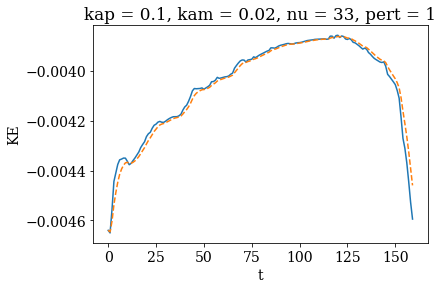

In [11]:
toplot = (dsp["KE"].differentiate("t")/(0+1*dsp["KE"])).sel(kap=0.1, kam=0.02)
toplot.plot()
toplot.rolling_exp(t=5).mean().plot(linestyle="--")

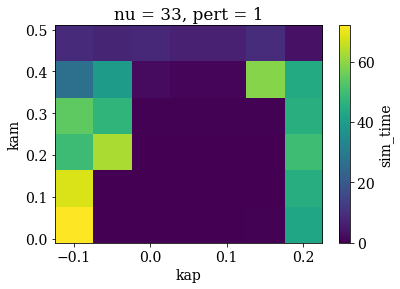

In [23]:
dsp.sim_time.isel(t=dsp["KE"].differentiate("t").argmin("t")).plot.imshow()

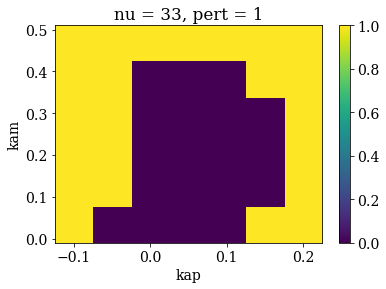

In [37]:
tronc = 5e-5
fig, ax = plt.subplots(1, 1)
(dMEdt>tronc).max("t").plot.imshow(ax=ax, x="kap")

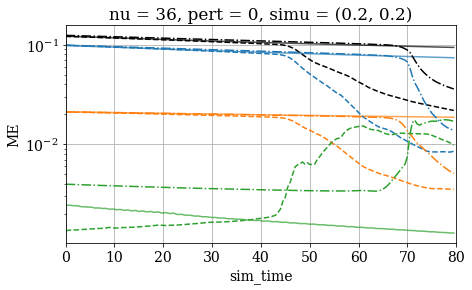

In [70]:
lstys = ["-", "--", "-."]
alphs = [.7, 1, 1]
fig, ax = plt.subplots(1, 1, figsize=(7,4))
for il in range(dsp.simu.size):
    for what in ["Etot", "KE", "PE", "ME"]:
        dsp.isel(simu=il)[what].plot.line(ax=ax, x="sim_time", color=cols[what], 
                                          linestyle=lstys[il], alpha=alphs[il])
ax.grid(True)
ax.set_xlim([round(float(dsp.sim_time.min())), round(float(dsp.sim_time.max()))])
ax.set_yscale("log")

In [ ]:
lstys = ["-", "--", "-."]
alphs = [.7, 1, 1]
fig, ax = plt.subplots(1, 1, figsize=(10,4))
for il in range(dsp.simu.size):
    for what in ["Etot", "KE", "PE", "ME"]:
        dsp.isel(simu=il)[what].plot.line(ax=ax, x="sim_time", color=cols[what], 
                                          linestyle=lstys[il], alpha=alphs[il])
ax.grid(True)
ax.set_yscale("log")

## Link between propagation speed and KE

In [7]:
params = {"kapext":[-0.1, 0, 0.05, 0.1, 0.2], 
          "kapint":[0, 0.1, 0.2], 
          "pert":[True, False], "nu":[33, 36]}
       #   "pert":[True, False], "nu":[15, 16, 17]}

#params.update({k:params[k][-1:] for k in ["kapint"]})
%time ds = load_big_ds(params)
ds

CPU times: user 5.44 s, sys: 256 ms, total: 5.7 s
Wall time: 7.4 s


<xarray.Dataset>
Dimensions:    (kap: 5, kam: 3, nu: 2, pert: 2, t: 160, x: 512, y: 512)
Coordinates:
  * kap        (kap) float64 -0.1 0.0 0.05 0.1 0.2
  * kam        (kam) float64 0.0 0.1 0.2
  * nu         (nu) int64 33 36
  * pert       (pert) object False True
    iteration  (pert, nu, kam, kap, t) int64 0 353 705 ... 32148 32213 32278
    sim_time   (pert, nu, kam, kap, t) float64 0.0 0.5009 1.001 ... 79.0 79.5
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * x          (x) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
  * y          (y) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
Data variables:
    b          (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 512, 512), meta=np.ndarray>
    psi        (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 512, 512), meta=np.ndarray>
    vort       (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 10, 512, 512), meta=np.ndarray>
Attributes:
    dx:       0.019531249999999997
    dy:       0.019531249999999997

In [8]:
def xunwrap(posx):
    offset = ds.x.size//2
    delx = ds.x.size
    dx = ds.dx
    x_pos = xr.apply_ufunc(lambda y: np.unwrap(y,axis=-1), (posx-offset)*2*np.pi/delx, 
                           input_core_dims=[["t"]], dask="parallelized",
                           output_core_dims=[["t"]]
                          )
    x_pos = (x_pos*delx/2/np.pi + offset) * dx + ds.x[0]
    return x_pos


In [9]:
duv = get_grad(ds)
posx = ((duv.u**2 + duv.v**2)**.5).max("y").argmax("x")
%time posx = custom_distribute(posx, ["kap", "kam"]).chunk({"t":-1})
x_pos = xunwrap(posx)
x_vec = x_pos.differentiate("t").compute()

iterating over kam: iterating over kap: 0, 1, 2, 3, 4, -- kap done
iterating over kap: 0, 1, 2, 3, 4, -- kap done
iterating over kap: 0, 1, 2, 3, 4, -- kap done
-- kam done
CPU times: user 3min 50s, sys: 6.74 s, total: 3min 56s
Wall time: 5min 42s


In [11]:
dst = x_pos.to_dataset(name="pos_x")
dst["vec_x"] = x_vec
dst["pert"] = dst.pert.astype(int)

dst.to_netcdf("velocity.nc")

In [16]:
dsp = xr.open_dataset("tseries_integrated_vs-kap-kam_1nu.nc")
if "Etot" not in dsp:
    dsp["Etot"] = dsp.KE + dsp.PE + dsp.ME
dsp

<xarray.Dataset>
Dimensions:    (kap: 7, kam: 6, nu: 2, pert: 2, t: 160)
Coordinates:
  * kap        (kap) float64 -0.1 -0.05 0.0 0.02 0.05 0.1 0.2
  * kam        (kam) float64 0.0 0.02 0.05 0.1 0.2 0.5
  * nu         (nu) int64 33 36
  * pert       (pert) int64 0 1
    iteration  (pert, nu, kam, kap, t) int64 ...
    sim_time   (pert, nu, kam, kap, t) float64 ...
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
Data variables:
    ME         (kap, kam, nu, pert, t) float64 ...
    KE         (kap, kam, nu, pert, t) float64 ...
    PE         (kap, kam, nu, pert, t) float64 ...
    Z          (kap, kam, nu, pert, t) float64 ...
    Etot       (kap, kam, nu, pert, t) float64 0.1198 0.1194 ... 0.02877 0.02868

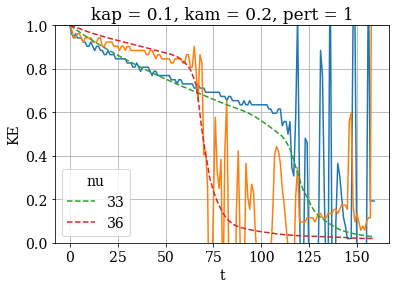

In [58]:
kap, kam, pert = 0.1, 0.2, 1
x_vec = dst.vec_x
(x_vec/x_vec.isel(t=0)).sel(kap=kap, kam=kam, pert=pert).plot.line(x="t")
((dsp.KE/dsp.KE.isel(t=0))**1.4).sel(kap=kap, kam=kam, pert=pert).plot.line(x="t", linestyle="--")
plt.ylim([0, 1])
plt.grid(True)

In [59]:
2**.5

1.4142135623730951

## Old stuff

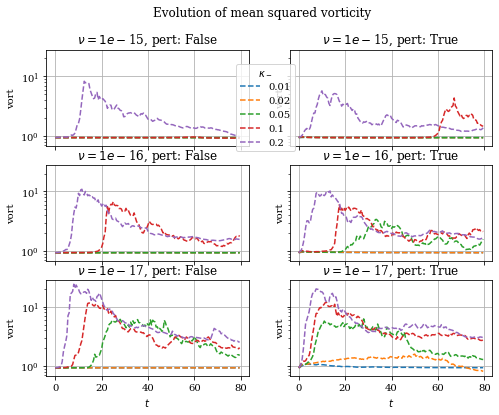

In [14]:
### every values of kappa int on each plot

row, col = "nu", "pert"

fig, axs = plt.subplots(toplot[row].size, toplot[col].size, sharex=True, sharey=True, 
                        figsize=(4*toplot[col].size,3*toplot[col].size))
for ic,ir in itertools.product(range(toplot[col].size),range(toplot[row].size)):
    ax = axs[ir,ic]
    dat = toplot.isel({col:ic,row:ir}).squeeze()
    hla = dat.plot.line(x="sim_time", hue="kam", linestyle="--", ax=ax, add_legend=False)
    ax.grid(True)
    ax.set_title(r"$\nu=1e-$"+str(int(dat.nu))+", pert: {}".format(bool(dat.pert)))
    ax.set_yscale("log")
    #ax.set_xscale("log")
axs[0,1].legend(hla, dat.kam.values, title=r"$\kappa_-$", bbox_to_anchor=(0.05,.9))
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$t$")
    
fig.suptitle("Evolution of {}".format(long_name))

if do_savefig:
    figname = "tseries_norm{}_vsKappa_allnupert.pdf".format(what)
    fig.savefig(dirpic/figname, bbox_inches="tight")

### Sensitvity to $\kappa_+$ and $\kappa_-$

In [6]:
params = {"kapext":[0, 0.01, 0.02, 0.05, 0.1, 0.2], "kapint":[0, 0.01, 0.02, 0.05, 0.1, 0.2], 
          "pert":[True, False], "nu":[16]}
       #   "pert":[True, False], "nu":[15, 16, 17]}
list_params = [l for l in dict_product(params)]
params = {"kapext":[-0.01, -0.02, -0.05, -0.1], "kapint":[0, 0.01, 0.02, 0.05, 0.1], 
          "pert":[False], "nu":[16]}
list_params += [l for l in dict_product(params)]
ds = load_big_ds(list_params)
ds

/home1/datahome/nlahaye/conda-env/dedalus/lib/python3.7/site-packages/dask/array/core.py:4345: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,
/home1/datahome/nlahaye/conda-env/dedalus/lib/python3.7/site-packages/dask/array/core.py:4345: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,
/home1/datahome/nlahaye/conda-env/dedalus/lib/python3.7/site-packages/dask/array/core.py:4345: PerformanceWarning: Increasing number of chunks by factor of 36
  **blockwise_kwargs,


<xarray.Dataset>
Dimensions:    (kam: 6, kap: 10, nu: 1, pert: 2, t: 160, x: 512, y: 512)
Coordinates:
  * kap        (kap) float64 -0.1 -0.05 -0.02 -0.01 0.0 0.01 0.02 0.05 0.1 0.2
  * kam        (kam) float64 0.0 0.01 0.02 0.05 0.1 0.2
  * nu         (nu) int64 16
  * pert       (pert) object False True
    iteration  (pert, kap, kam, t) float64 0.0 354.0 ... 3.175e+04 3.189e+04
    sim_time   (pert, kap, kam, t) float64 0.0 0.5005 1.0 1.5 ... 78.5 79.0 79.5
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
  * x          (x) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
  * y          (y) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
Data variables:
    b          (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 1, 512, 512), meta=np.ndarray>
    psi        (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 1, 512, 512), meta=np.ndarray>
    vort       (kap, kam, nu, pert, t, x, y) float64 dask.array<chunksize=(1, 1, 1, 1, 1, 512, 512), meta=np.ndarray>
Attributes:
    dx:       0.019531249999999997
    dy:       0.019531249999999997

In [37]:
client.restart()

<Client: 'tcp://127.0.0.1:43356' processes=4 threads=4, memory=16.00 GiB>

In [45]:
abs(ds.isel(t=0).b).mean(dim=("x","y")).values

array([[[[0.        , 0.00010222],
         [0.        , 0.00010222]],

        [[0.0026309 , 0.00269356],
         [0.0026309 , 0.00269356]]],


       [[[0.01223667, 0.01223651],
         [0.01223667, 0.01223651]],

        [[0.0148846 , 0.01488444],
         [0.0148846 , 0.01488444]]]])

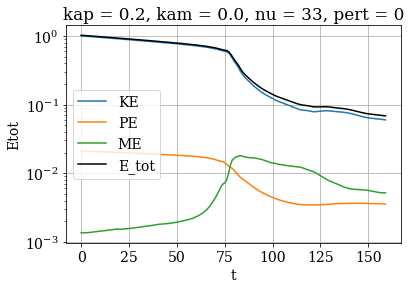

In [64]:
sds = ds_synth.sel(kam=0, kap=0.2, nu=33, pert=0)
col = {"ke":"tab:blue", "pe":"tab:orange", "me":"tab:green"}

fig, ax = plt.subplots(1, 1)
bx = ax#.twinx()
sds.KEsqr.plot(ax=ax, color=col["ke"], label="KE")
sds.PEsqr.plot(ax=bx, color=col["pe"], label="PE")
sds.Asqr.plot(ax=bx, color=col["me"], label="ME")
sds.Etot.plot(ax=ax, color="k", label=r"E_tot")
ax.grid(True)
ax.set_yscale("log")
ax.legend()

In [54]:
### eveto_netcdf of kappa int on each plot

what = "vort"
row, col = "kap", "pert"

toplot = ds_synth[what+"sqr"]
long_name = long_names[what]
nr = int((toplot[row]>=0).sum())
plt.rcParams["axes.prop_cycle"] = mpl.cycler('color', ['k', '#1f77b4', '#ff7f0e', '#2ca02c', 
                                                       '#d62728', '#9467bd', '#8c564b', 
                                                       '#e377c2', '#7f7f7f', '#bcbd22', 
                                                       '#17becf']
                                            )

fig, axs = plt.subplots(nr, toplot[col].size+1, sharex=True, sharey=True, 
                        figsize=(4*(toplot[col].size+1),3*nr))
for ir,kap in enumerate(toplot.kap.where(toplot.kap>=0, drop=True)):
    kap = float(kap)
    for ic in range(toplot[col].size):
        ax = axs[ir,ic+1]
        dat = toplot.isel({col:ic}).sel(kap=kap).squeeze()
        hla = dat.plot.line(x="sim_time", hue="kam", linestyle="--", ax=ax, add_legend=False)
        hla[list(dat.kam.values).index(kap)].set_linestyle('-')
        ax.grid(True)
        ax.set_title(r"$\kappa_+=$"+"{:.2f}".format(kap)+", pert: {}".format(bool(dat.pert)))
        #ax.set_xscale("log")
    kap = -kap
    if kap not in toplot.kap or kap==0:
        continue
    ax = axs[ir,0]
    dat = toplot.isel(pert=False).sel(kap=kap).squeeze()
    hla = dat.plot.line(x="sim_time", hue="kam", linestyle="--", ax=ax, add_legend=False)
    #hla[list(dat.kam.values).index(kap)].set_linestyle('-')
    ax.grid(True)
    ax.set_title(r"$\kappa_+=$"+"{:.2f}".format(kap)+", pert: {}".format(bool(dat.pert)))
axs[0,0].legend(hla, dat.kam.values, title=r"$\kappa_-$", bbox_to_anchor=(.5,.9))

if what not in ["KE"]:
    for ax in axs.ravel():
        ax.set_yscale("log")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$t$")
for ax in axs[:,1:].ravel():
    ax.set_ylabel("")
    
fig.suptitle("Evolution of {}".format(long_name), y=.95)

if do_savefig:
    figname = "tseries_norm{}_vsKappaInt_allkapextpert.pdf".format(what)
    fig.savefig(dirpic/figname, bbox_inches="tight")

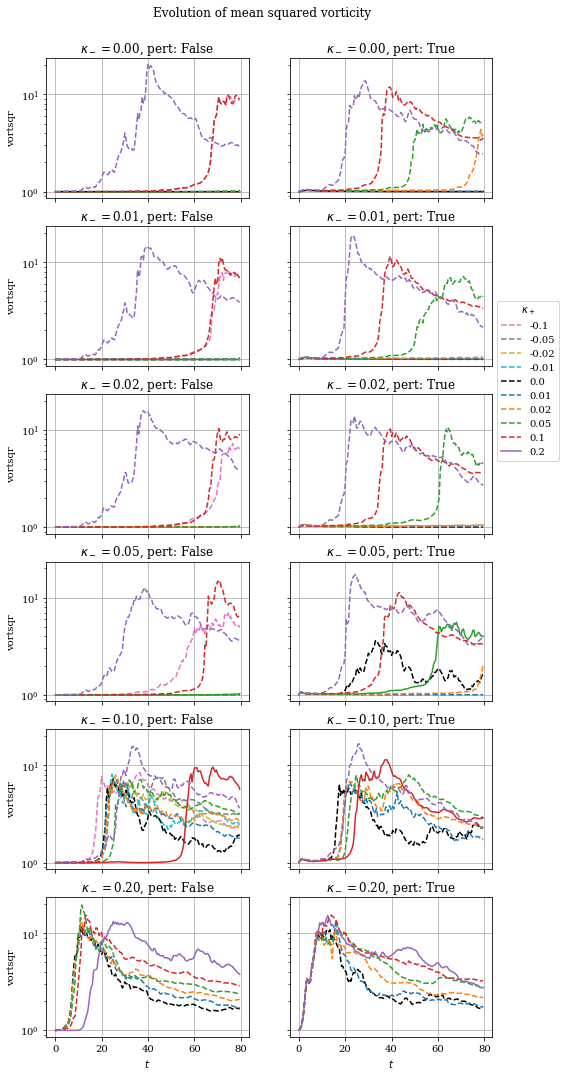

In [55]:
### eveto_netcdf of kappa int on each plot

#what = "A"
row, col = "kam", "pert"

toplot = ds_synth[what+"sqr"]
long_name = long_names[what]
nr = int((toplot[row]>=0).sum())

def_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams["axes.prop_cycle"] = mpl.cycler(color=list(np.roll(def_cycle, 4)))

fig, axs = plt.subplots(nr, toplot[col].size, sharex=True, sharey=True, 
                        figsize=(4*toplot[col].size,3*nr))
for ic,ir in product(range(toplot[col].size), range(toplot[row].size)):
    ax = axs[ir,ic]
    dat = toplot.isel({col:ic,row:ir}).squeeze()
    kam = float(dat.kam.values)
    hla = dat.plot.line(x="sim_time", hue="kap", linestyle="--", ax=ax, add_legend=False)
    hla[list(dat.kap.values).index(kam)].set_linestyle('-')
    ax.grid(True)
    ax.set_title(r"$\kappa_-=$"+"{:.2f}".format(kam)+", pert: {}".format(bool(dat.pert)))
    
axs[1,1].legend(hla, dat.kap.values, title=r"$\kappa_+$", bbox_to_anchor=(1.,.5))

if what not in ["KE"]:
    for ax in axs.ravel():
        ax.set_yscale("log")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$t$")
for ax in axs[:,1:].ravel():
    ax.set_ylabel("")
    
fig.suptitle("Evolution of {}".format(long_name), y=.92)

if do_savefig:
    figname = "tseries_norm{}_vsKappaext_allkapintpert.pdf".format(what)
    fig.savefig(dirpic/figname, bbox_inches="tight")
    
plt.rcParams["axes.prop_cycle"] = mpl.cycler(color=def_cycle)


#### couple regular/hollow/no ext for each value of kappa

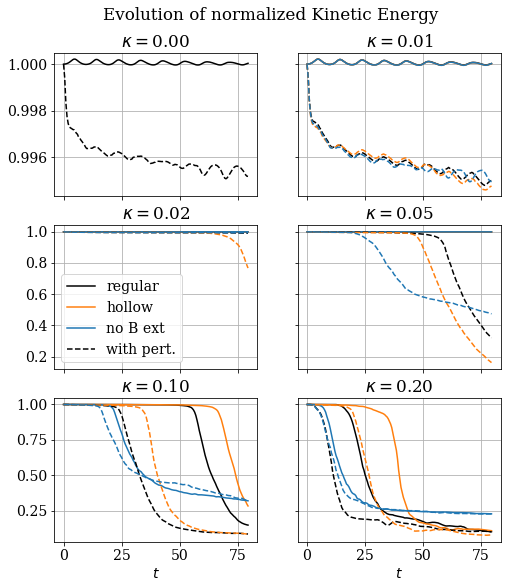

In [11]:
### eveto_netcdf of kappa int on each plot

what = "KE"
kappas = ds_synth.kam.where(ds_synth.kam>0, drop=True).values

toplot = ds_synth[what+"sqr"]
long_name = long_names[what]
nr = (len(kappas)+1)//2
nc = 2
my_cols = {"reg":"k", "noext":"tab:blue", "hollow":"tab:orange"}
my_lins = ["-", "--"]

fig, axs = plt.subplots(nr, nc, sharex=True, sharey="row", 
                        figsize=(4*nc,3*nr))
ax = axs[0,0]
for p in (True, False):
    toplot.sel(kap=0, kam=0, pert=int(p)).plot(ax=ax, color=my_cols["reg"], 
                                               linestyle=my_lins[p], x="sim_time")
ax.set_title(r"$\kappa=$"+"{:.2f}".format(0))
pstr = ("no pert.", "pert.")

for ik,kap in enumerate(kappas):
    ax = axs.ravel()[ik+1]
    kap = float(kap)
    for p in range(2):
        toplot.sel(kap=kap,kam=kap,pert=p).plot(ax=ax, color=my_cols["reg"],
                                                linestyle=my_lins[p], label="regular", 
                                                x="sim_time")
        toplot.sel(kap=kap,kam=0,pert=p).plot(ax=ax, color=my_cols["hollow"], 
                                              linestyle=my_lins[p], label="hollow", 
                                                x="sim_time")
        toplot.sel(kap=0,kam=kap,pert=p).plot(ax=ax, color=my_cols["noext"], 
                                              linestyle=my_lins[p], label="no B ext", 
                                                x="sim_time")
    ax.set_title(r"$\kappa=$"+"{:.2f}".format(kap))

if what not in ["KE"]:
    for ax in axs.ravel():
        ax.set_yscale("log")
for ax in axs.ravel():
    ax.grid(True)
    ax.set_ylabel("")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$t$")
lins, labs = axs[1,0].get_legend_handles_labels()
labs[3] = "with pert."
axs[1,0].legend(lins[:4], labs[:4], loc='best')

fig.suptitle("Evolution of {}".format(long_name), y=.95)

if do_savefig:
    figname = "tseries_norm{}_kappacouples.pdf".format(what)
    fig.savefig(dirpic/figname, bbox_inches="tight")
    

## high resolution runs

In [9]:
params = {"kapext":[0, 0.1], "kapint":[0., 0.1], 
          "pert":[True, False], "nu":[16]}
       #   "pert":[True, False], "nu":[15, 16, 17]}
list_params = [l for l in dict_product(params)]
list_params = list_params[2:] # remove non-magnetic modons

ds = load_big_ds(list_params, simuls=simuls.replace("N512","N1024"))
ds

In [14]:
%%time
#### compute
for what in ["A","KE","vort"]:
    print("computing", what)
    sds = custom_distribute(comp_int_field(ds, what), ["kap"]).to_dataset()
    sds = sds.assign_coords(pert=sds.coords["pert"].astype(int))
    sds.to_netcdf(what+".nc")
    client.restart()#.persist()
del sds

ds_synth = xr.merge([xr.open_dataset(what+".nc") for what in ["A","KE","vort"]])
ds_synth.to_netcdf("tseries_integrated_hres1024.nc")

computing A
iterating over kap: 0, 1, -- kap done
computing KE
iterating over kap: 0, 1, -- kap done
computing vort
iterating over kap: 0, 1, -- kap done
CPU times: user 3min 42s, sys: 7.22 s, total: 3min 49s
Wall time: 5min 46s


In [7]:
# you must have loaded low res run before
ds_synth = xr.open_dataset("tseries_integrated_vs-kap-kam.nc")
ds_hres = xr.open_dataset("tseries_integrated_hres1024.nc")
ds_synth = xr.concat([ds_synth.expand_dims({"N":[512]}), ds_hres.expand_dims({"N":[1024]})],
                    dim="N")
ds_synth

<xarray.Dataset>
Dimensions:    (N: 2, kam: 6, kap: 10, nu: 1, pert: 2, t: 160)
Coordinates:
  * kam        (kam) float64 0.0 0.01 0.02 0.05 0.1 0.2
  * kap        (kap) float64 -0.1 -0.05 -0.02 -0.01 0.0 0.01 0.02 0.05 0.1 0.2
  * N          (N) int64 512 1024
  * nu         (nu) int64 16
  * pert       (pert) int64 0 1
    iteration  (N, pert, kap, kam, t) float64 0.0 354.0 707.0 ... nan nan nan
    sim_time   (N, pert, kap, kam, t) float64 0.0 0.5005 1.0 1.5 ... nan nan nan
  * t          (t) int64 0 1 2 3 4 5 6 7 8 ... 152 153 154 155 156 157 158 159
Data variables:
    Asqr       (N, kap, kam, nu, pert, t) float64 1.0 0.9883 0.9866 ... nan nan
    KEsqr      (N, kap, kam, nu, pert, t) float64 1.0 1.0 1.0 ... nan nan nan
    vortsqr    (N, kap, kam, nu, pert, t) float64 1.0 1.0 1.0 ... nan nan nan

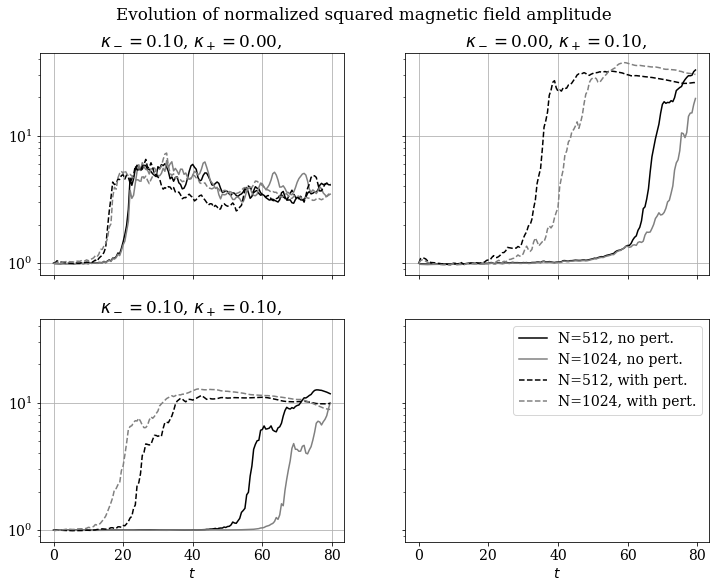

In [37]:
### eveto_netcdf of kappa int on each plot

what = "A"

toplot = ds_synth[what+"sqr"]
long_name = long_names[what]
nr = (len(kappas)+1)//2
nc = 2
my_cols = {512:"k", 1024:"grey"}
my_lins = ["-", "--"]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, 
                        figsize=(12,9))
kaps = [0., 0.1, 0.1]
kams = [0.1, 0., 0.1]

for i in range(len(kaps)):
    ax, kap, kam = axs.ravel()[i], kaps[i], kams[i]
    toplot = ds_synth[what+"sqr"].sel(kap=kap, kam=kam)
    for p,n in product(range(2),toplot.N.values):
        pstr = "with pert." if p==1 else "no pert."
        toplot.sel(pert=p, N=n).plot(ax=ax, color=my_cols[n], 
                                     linestyle=my_lins[p], x="sim_time",
                                    label=r"N={}, ".format(n)+pstr)
    ax.set_title(r"$\kappa_-=$"+"{:.2f}, ".format(kam)+r"$\kappa_+=$"+"{:.2f}, ".format(kap))
    ax.grid(True)
    ax.set_ylabel("")
if what not in ["KE"]:
    for ax in axs.ravel():
        ax.set_yscale("log")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$t$")
lins, labs = axs[0,0].get_legend_handles_labels()
axs[1,1].legend(lins, labs)

fig.suptitle("Evolution of {}".format(long_name), y=.95)

if do_savefig:
    figname = "tseries_norm{}_vs-res.pdf".format(what)
    fig.savefig(dirpic/figname, bbox_inches="tight")
    

### spectra, comparing different resolutions

In [78]:
params = {"kapext":[0, 0.1], "kapint":[0., 0.1], 
          "pert":[True, False], "nu":[16]}
       #   "pert":[True, False], "nu":[15, 16, 17]}
list_params = [l for l in dict_product(params)]

ds_lr = load_big_ds(list_params).expand_dims({"N":[512]})
list_params = list_params[2:] # remove non-magnetic modons
ds_hr = load_big_ds(list_params, simuls=simuls.replace("N512","N1024")).expand_dims({"N":[1024]})

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


In [79]:
### routines for computing power spectra using FFT
# not cool because not dask permissing
def get_spec(data, n_bins=100):
    """ returns k*azimuthal average of spectrum """
    daft = xrscipy.fft.fftn(data.load(), "x", "y")
    daft = daft.assign_coords(modk=(daft.x**2 + daft.y**2)**.5)
    return (daft*daft.conj()*daft.modk).real.groupby_bins("modk",n_bins).mean()

def get_hke_spec(da_psi, n_bins=100):
    """ compute HKE spectrum from streamfunction """
    daft = xrscipy.fft.fftn(da_psi.load(), "x", "y")
    daft = daft.assign_coords(modk=(daft.x**2 + daft.y**2)**.5)    
    return (.5*daft*daft.conj()*daft.modk**3).real.groupby_bins("modk",n_bins).mean()

In [56]:
### select a few runs and plot spectra evolution for each of them
runs = [{k.replace("pext","p").replace("pint","m"):tab[k] for k in ("kapext","kapint","pert")} for tab in list_params]
runs = [{"kap":0, "kam":0, "pert":False}]+runs # low res only

times = [0, 20, 40, 80] # time indices -- easier for selecting
fie = "b"

### this is not optimal at all
dspec = xr.concat([xr.concat([
            get_hke_spec(ds_lr[fie].sel(**run).swap_dims({"t":"sim_time"})\
                                    .sel(sim_time=tim, method="nearest")) 
                   for tim in times], dim="t")
                   for run in runs], dim="run")
dspec = dspec.persist()

dspec

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray (run: 7, t: 4, N: 1, nu: 1, modk_bins: 100)>
array([[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


        [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]],



       [[[[3.24302982e+02, 2.86243152e+03, 1.38000608e+03, ...,
           5.02033383e-01, 5.78686770e-01, 6.17146510e-01]]],

...

        [[[4.06285001e+04, 1.36997990e+04, 4.98813091e+03, ...,
           6.32774423e-06, 4.35034513e-06, 1.53691442e-06]]]],



       [[[[3.86199284e+03, 4.15185645e+03, 4.73127688e+02, ...,
           5.79435488e-08, 6.01969530e-08, 6.21724044e-08]]],


        [[[3.86607440e+03, 4.14735013e+03, 4.70739293e+02, ...,
           1.83722513e-09, 7.49480181e-10, 2.04538217e-10]]],


        [[[3.84399305e+03, 4.13923089e+03, 4.73798887e+02, ...,
           3.28439164e-11, 2.08597296e-11, 1.37333316e-11]]],


        [[[1.66091115e+04, 1.65841322e+04, 1.19962839e+04, ...,
           2.90128998e-04, 2.35491745e-04, 1.45536568e-04]]]]])
Coordinates:
  * modk_bins  (modk_bins) object (-0.0362, 0.362] ... (35.842, 36.204]
    kap        (run) float64 0.0 0.0 0.0 0.1 0.1 0.1 0.1
    kam        (run) float64 0.0 0.1 0.1 0.0 0.0 0.1 0.1
    pert       (run) bool False True False True False True False
    iteration  (run, t) int64 0 14108 28214 56075 0 ... 0 14132 28264 51164
    sim_time   (run, t) float64 0.0 20.0 40.0 79.5 0.0 ... 0.0 20.0 40.0 79.5
  * t          (t) int64 0 40 80 159
  * N          (N) int64 512
  * nu         (nu) int64 16
Dimensions without coordinates: run

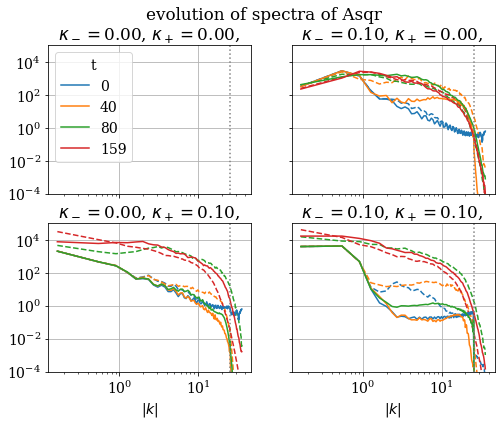

In [58]:
### plotting

mylins = ["-","--"]
strnam = {"psi":"KE", "b":"Asqr"}[fie]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, 
                        figsize=(4*2,3*2))
for ii in range(dspec.run.size):
    toplot = dspec.isel(run=ii).squeeze()
    kap, kam, pert = float(toplot.kap), float(toplot.kam), int(toplot.pert)
    ax = axs[int(kap>0),int(kam>0)]
    ax.set_prop_cycle(None)
    hla = toplot.plot.line(hue="t", linestyle=mylins[pert], ax=ax, add_legend=(kap+kam==0))
    ax.set_title(r"$\kappa_-=$"+"{:.2f}, ".format(kam)+r"$\kappa_+=$"+"{:.2f}, ".format(kap))

linx = .5/ds_lr.dx

if fie in ["psi"]:
    ax.set_ylim([1e-9, 1e6])
elif fie in ["b"]:
    ax.set_ylim([1e-4, 1e5])

for ax in axs.ravel():
    limx = [1./ds_lr.x.max(), linx*2**.5]
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.axvline(linx, color="grey", linestyle=":")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$|k|$")
for ax in axs[:,1:].ravel():
    ax.set_ylabel("")
letit = "evolution of spectra of "+strnam
fig.suptitle(letit, y=.97)

if do_savefig:
    figname = "spectra_tevol_{}_N512.pdf".format(strnam)
    fig.savefig(dirpic/figname, bbox_inches="tight")
    

In [80]:
### select a few runs and plot spectra evolution for each of them
runs = [{k.replace("pext","p").replace("pint","m"):tab[k] for k in ("kapext","kapint","pert")} for tab in list_params]

times = [0, 20, 40, 80] # time indices -- easier for selecting
fie = "psi"

### this is not optimal at all
dspec = xr.concat([xr.concat([
            get_hke_spec(ds_hr[fie].sel(**run).swap_dims({"t":"sim_time"})\
                                    .sel(sim_time=tim, method="nearest")) 
                   for tim in times], dim="t")
                   for run in runs], dim="run")
dspec = dspec.persist()

dspec

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray (run: 6, t: 4, N: 1, nu: 1, modk_bins: 100)>
array([[[[[6.49796030e+06, 3.20241489e+05, 1.76712734e+03, ...,
           1.11181143e-07, 4.60507638e-08, 2.52944934e-08]]],


        [[[5.00994122e+06, 1.60297788e+05, 1.88553859e+04, ...,
           7.15529148e-15, 2.79264841e-15, 8.15645532e-16]]],


        [[[1.85747414e+06, 9.67688561e+04, 4.92111690e+04, ...,
           1.45024554e-17, 6.77425024e-18, 3.90190289e-18]]],


        [[[1.31944005e+06, 8.67189148e+04, 2.96224928e+04, ...,
           1.50192174e-19, 7.50553087e-20, 3.62360553e-20]]]],



       [[[[6.49793770e+06, 3.20251559e+05, 1.76840600e+03, ...,
           1.10920806e-07, 4.59318425e-08, 2.51793150e-08]]],

...

        [[[2.33123486e+05, 7.72898003e+04, 4.19624859e+04, ...,
           3.83484689e-21, 2.23848968e-21, 1.18757618e-21]]]],



       [[[[6.51645723e+06, 3.21335863e+05, 1.76846090e+03, ...,
           2.09465765e-07, 1.34766472e-07, 8.78969042e-08]]],


        [[[6.51672245e+06, 3.20949807e+05, 1.73500659e+03, ...,
           8.66556852e-22, 1.03746200e-21, 2.67390303e-21]]],


        [[[6.51216136e+06, 3.19729879e+05, 1.77521928e+03, ...,
           7.92529833e-22, 1.25082055e-21, 2.27864878e-21]]],


        [[[1.78632561e+06, 6.13205391e+04, 2.08412209e+04, ...,
           2.62169578e-15, 1.44271241e-15, 3.00051616e-16]]]]])
Coordinates:
  * modk_bins  (modk_bins) object (-0.0724, 0.724] ... (71.684, 72.408]
    kam        (run) float64 0.1 0.1 0.0 0.0 0.1 0.1
    kap        (run) float64 0.0 0.0 0.1 0.1 0.1 0.1
    pert       (run) bool True False True False True False
    iteration  (run, t) int64 0 28487 50395 76839 0 ... 0 28262 56525 110174
    sim_time   (run, t) float64 0.0 20.0 40.0 79.5 0.0 ... 0.0 20.0 40.0 79.5
  * t          (t) int64 0 40 80 159
  * N          (N) int64 1024
  * nu         (nu) int64 16
Dimensions without coordinates: run

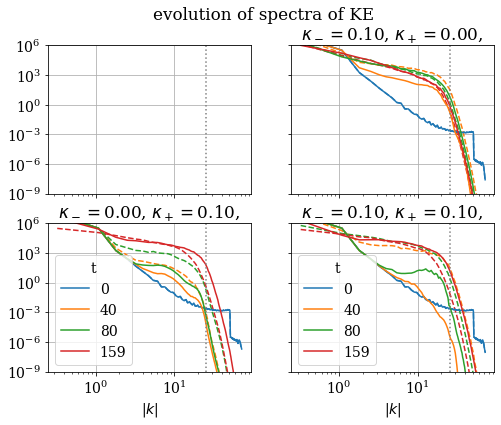

In [82]:
### plotting

mylins = ["-","--"]
strnam = {"psi":"KE", "b":"Asqr"}[fie]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, 
                        figsize=(4*2,3*2))
for ii in range(dspec.run.size):
    toplot = dspec.isel(run=ii).squeeze()
    kap, kam, pert = float(toplot.kap), float(toplot.kam), int(toplot.pert)
    ax = axs[int(kap>0),int(kam>0)]
    ax.set_prop_cycle(None)
    hla = toplot.plot.line(hue="t", linestyle=mylins[pert], ax=ax,
                           add_legend=kap>0)
    ax.set_title(r"$\kappa_-=$"+"{:.2f}, ".format(kam)+r"$\kappa_+=$"+"{:.2f}, ".format(kap))

linx = .5/ds_lr.dx

if fie in ["psi"]:
    ax.set_ylim([1e-9, 1e6])
elif fie in ["b"]:
    ax.set_ylim([1e-4, 1e5])

for ax in axs.ravel():
    limx = [1./ds_lr.x.max(), linx*2**.5]
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.axvline(linx, color="grey", linestyle=":")
for ax in axs[:-1,:].ravel():
    ax.set_xlabel("")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$|k|$")
for ax in axs[:,1:].ravel():
    ax.set_ylabel("")
letit = "evolution of spectra of "+strnam
fig.suptitle(letit, y=.97)

if do_savefig:
    figname = "spectra_tevol_{}_N1024.pdf".format(strnam)
    fig.savefig(dirpic/figname, bbox_inches="tight")
    